In [1]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

# load PLUTO data


In [2]:
pluto_ogrio = ogr.read_dataframe("../Data/DEP Green Infrastructure/geo_export_3298f6ed-a61a-4d9f-a900-907faeaebf16.shp")

# basic exploration


In [3]:
pluto_ogrio.head()

,assembly_d,asset_area,asset_id,asset_leng,asset_type,asset_widt,asset_x_co,asset_y_co,bbl,borough,...,program_ar,project_na,row_onsite,secondary_,sewer_type,status,status_gro,tree_commo,tree_latin,geometry
0,32.0,85.0,94002.0,17.0,ROWB,5.0,1.036475e+06,191223.22700,4.095890e+09,Queens,...,Right of Way (ROW),DDC JAM-003 Phase 2,ROW,0.000000e+00,Combined,Constructed (Full Maintenance),Constructed,Chinese Fringetree,Chionanthus retusus,POINT (-73.81168 40.69139)
1,32.0,45.5,94012.0,13.0,ROWGS,3.5,1.036305e+06,191586.59230,4.095020e+09,Queens,...,Right of Way (ROW),DDC JAM-003 Phase 2,ROW,4.095020e+09,Combined,Constructed (Full Maintenance),Constructed,N/A,No Tree,POINT (-73.81229 40.69238)
2,32.0,70.0,94017.0,20.0,ROWGS,3.5,1.036319e+06,191856.45894,4.095030e+09,Queens,...,Right of Way (ROW),DDC JAM-003 Phase 2,ROW,0.000000e+00,Combined,Constructed (Full Maintenance),Constructed,N/A,No Tree,POINT (-73.81223 40.69313)
3,32.0,70.0,94019.0,20.0,ROWGS,3.5,1.036368e+06,191874.29620,4.095030e+09,Queens,...,Right of Way (ROW),DDC JAM-003 Phase 2,ROW,0.000000e+00,Combined,Constructed (Full Maintenance),Constructed,N/A,No Tree,POINT (-73.81206 40.69317)
4,32.0,52.0,94021.0,13.0,ROWB,4.0,1.036079e+06,191735.02499,4.095020e+09,Queens,...,Right of Way (ROW),DDC JAM-003 Phase 2,ROW,0.000000e+00,Combined,Constructed (Full Maintenance),Constructed,Pin Oak,Quercus palustris,POINT (-73.81310 40.69279)


In [4]:
pluto_ogrio.columns

Index(['assembly_d', 'asset_area', 'asset_id', 'asset_leng', 'asset_type',
       'asset_widt', 'asset_x_co', 'asset_y_co', 'bbl', 'borough',
       'city_counc', 'community_', 'construc_1', 'constructi', 'dep_cont_1',
       'dep_contra', 'gi_feature', 'gi_id', 'nyc_waters', 'outfall',
       'program_ar', 'project_na', 'row_onsite', 'secondary_', 'sewer_type',
       'status', 'status_gro', 'tree_commo', 'tree_latin', 'geometry'],
      dtype='object')

In [5]:
pluto_ogrio.dtypes

assembly_d     float64
asset_area     float64
asset_id       float64
asset_leng     float64
asset_type      object
asset_widt     float64
asset_x_co     float64
asset_y_co     float64
bbl            float64
borough         object
city_counc     float64
community_     float64
construc_1      object
constructi      object
dep_cont_1      object
dep_contra      object
gi_feature      object
gi_id           object
nyc_waters      object
outfall         object
program_ar      object
project_na      object
row_onsite      object
secondary_     float64
sewer_type      object
status          object
status_gro      object
tree_commo      object
tree_latin      object
geometry      geometry
dtype: object

## categorical column


In [7]:
pluto_ogrio.nyc_waters.value_counts()

nyc_waters
Jamaica Bay and Tributaries    6596
Flushing Creek                 2179
East River / Open Waters       2004
Newtown Creek                  1579
Flushing Bay                    791
Bronx River                     441
Westchester Creek               224
Hutchinson River                194
Gowanus Canal                   124
Coney Island Creek               49
Alley Creek                       9
Name: count, dtype: int64

🧐 What do those numbers mean? Let's look at the [data dictionary](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/meta_mappluto.pdf)


In [8]:
pluto_ogrio.groupby(["borough","nyc_waters"]).asset_area.sum()

borough        nyc_waters                 
Bronx          Bronx River                     266832.95
               East River / Open Waters        380241.39
               Hutchinson River                169015.39
               Westchester Creek                45312.17
Brooklyn       Coney Island Creek               29461.00
               East River / Open Waters        484196.50
               Gowanus Canal                   325329.07
               Jamaica Bay and Tributaries     853994.35
               Newtown Creek                   199531.98
Manhattan      East River / Open Waters       1190239.03
Queens         Alley Creek                      16572.00
               Bronx River                        270.00
               East River / Open Waters        367460.22
               Flushing Bay                    148781.02
               Flushing Creek                  470109.87
               Jamaica Bay and Tributaries     541460.00
               Newtown Creek                 

<Axes: xlabel='borough'>

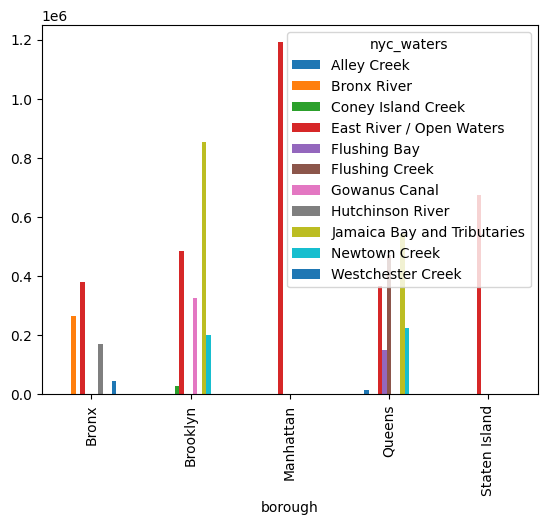

In [12]:
pluto_ogrio.groupby(["borough","nyc_waters"]).asset_area.sum().unstack().plot.bar()

<Axes: xlabel='nyc_waters'>

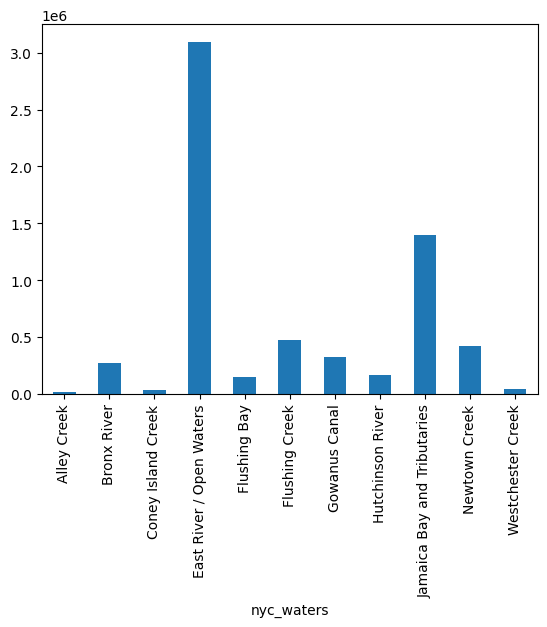

In [9]:
pluto_ogrio.groupby(["nyc_waters"]).asset_area.sum().plot.bar()

## Okay, now let's look at lot and building area


Text(0.5, 1.0, 'Total asset area by water drainage type')

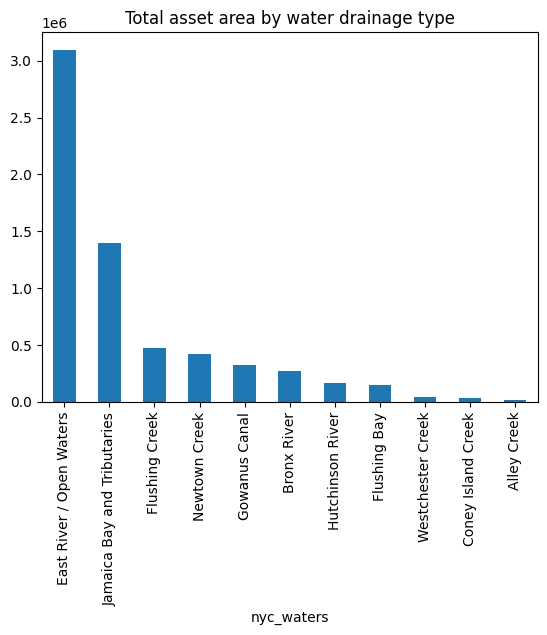

In [10]:
pluto_ogrio.groupby("nyc_waters").asset_area.sum().sort_values(ascending=False).plot.bar()
plt.title("Total asset area by water drainage")

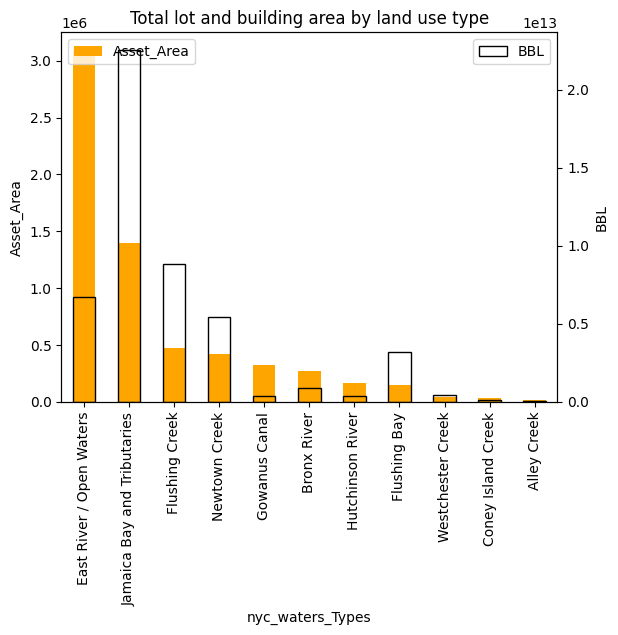

In [51]:
# plot both lot and building area on the same plot with a secondary y-axis
fig, ax = plt.subplots()
by_lot_area = pluto_ogrio.groupby("nyc_waters").asset_area.sum().sort_values(ascending=False)

by_lot_area.plot.bar(ax=ax, color="orange")

# get order to apply below
order = {v: i for i, v in enumerate(by_lot_area.index)}

ax.set_ylabel("Asset_Area")
ax.set_xlabel("nyc_waters_Types")

ax2 = ax.twinx()
pluto_ogrio.groupby("nyc_waters").bbl.sum().reindex(by_lot_area.index).plot.bar(
    ax=ax2, edgecolor="black", color="none"
)
ax2.set_ylabel("BBL")

plt.title("Total lot and building area by land use type")

# add legends
ax.legend(["Asset_Area"], loc="upper left")
ax2.legend(["BBL"], loc="upper right")

## numeric column


In [14]:
pluto_ogrio["asset_area"].describe()

count     14190.000000
mean        450.217921
std        5855.217598
min           1.000000
25%          50.000000
50%          65.000000
75%          93.500000
max      435000.000000
Name: asset_area, dtype: float64

<Axes: ylabel='Frequency'>

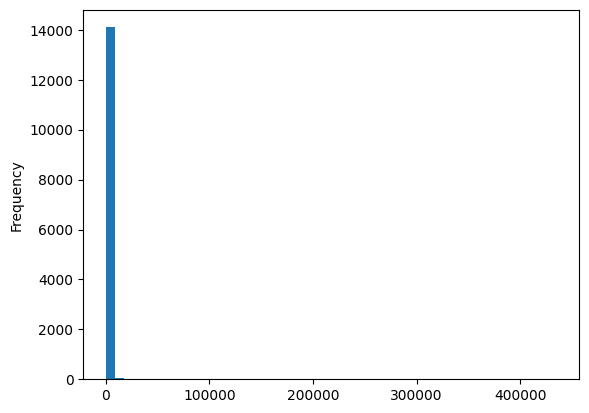

In [15]:
pluto_ogrio["asset_area"].plot.hist(bins=50)

## Your turn:

- make a histogram for each borough like above
- then, choose another chart type to visualize the distribution of lot area for each borough. See [here](https://matplotlib.org/stable/plot_types/index.html) for some built in options in matplotlib, or here for [seaborn](https://seaborn.pydata.org/tutorial/distributions.html)


## Ok, now let's make a boxplot to see how wide the range is within each boro's data


<Axes: title={'center': 'asset_area'}, xlabel='borough'>

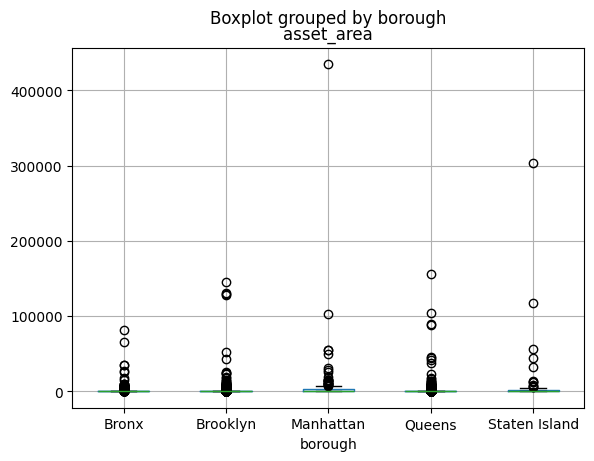

In [16]:
pluto_ogrio.boxplot(column="asset_area", by="borough")

What does this distribution tell us about the number of floors in each borough?


# cluster by number of floors


In [19]:
# get clusters using kmeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(pluto_ogrio[["bbl", "asset_area"]])

pluto_ogrio["NYC_Water_Cluster"] = kmeans.predict(pluto_ogrio[["bbl", "asset_area"]])NYC_Water_Cluster

In [21]:
pluto_ogrio.groupby("NYC_Water_Cluster").asset_area.describe().sort_values("max")

,count,mean,std,min,25%,50%,75%,max
NYC_Water_Cluster,,,,,,,,
3,1003.0,736.331256,2981.781163,1.0,58.500,80.42,244.155,65063.63
0,5802.0,342.696493,3906.288786,1.0,52.000,70.00,100.000,145471.00
1,7094.0,252.325960,2989.812811,1.0,50.000,60.00,80.000,156052.00
4,64.0,10555.157969,40972.968694,120.0,589.925,1079.80,2390.750,303481.00
2,227.0,5269.588238,30309.672771,40.0,142.070,582.48,2159.850,435000.00


<Axes: xlabel='asset_area', ylabel='bbl'>

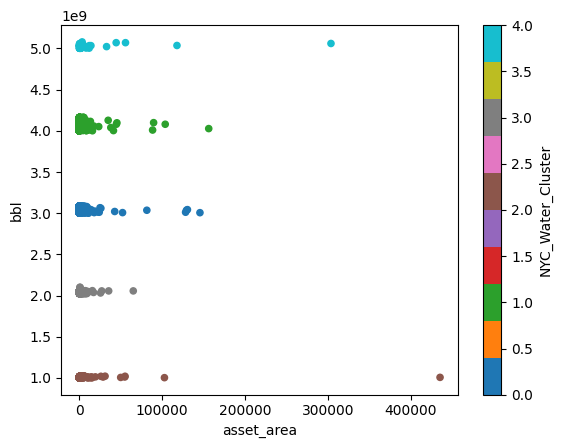

In [22]:
pluto_ogrio.plot.scatter(x="asset_area", y="bbl", c="NYC_Water_Cluster", cmap="tab10")

<Axes: xlabel='asset_area', ylabel='bbl'>

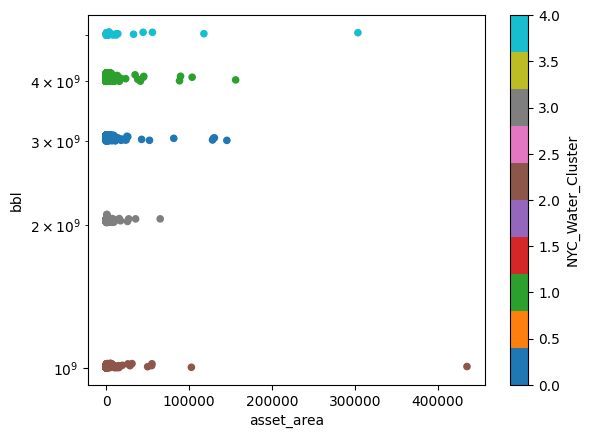

In [24]:
# same as above but with log y axis
pluto_ogrio.plot.scatter(
    x="asset_area", y="bbl", c="NYC_Water_Cluster", cmap="tab10", logy=True
)

<Axes: ylabel='Frequency'>

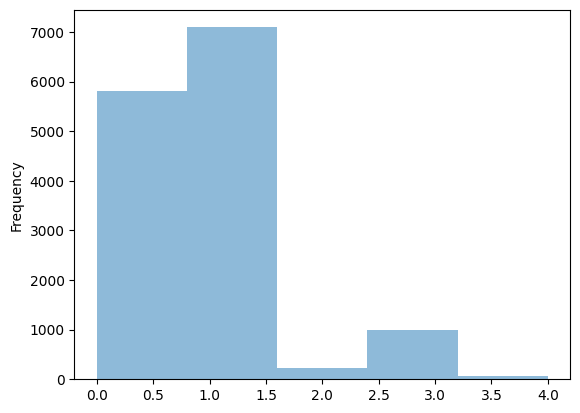

In [25]:
pluto_ogrio["NYC_Water_Cluster"].plot.hist(bins=5, alpha=0.5)

# and now, mapping


## static map


Text(0.5, 1.0, 'NYC MapPLUTO')

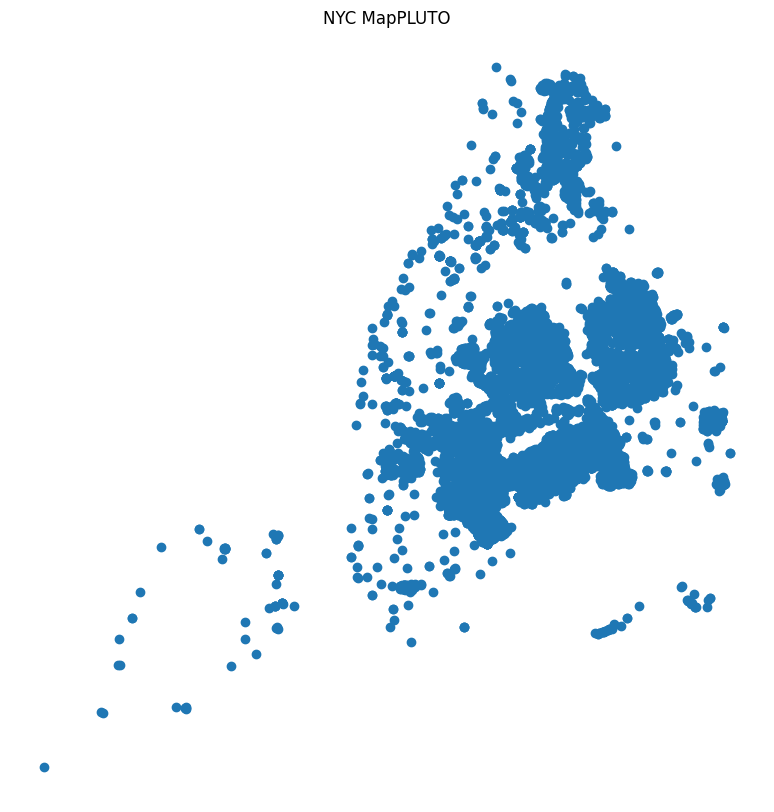

In [26]:
pluto_ogrio.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC MapPLUTO")

In [28]:
cmap = {
    "East River / Open Waters": "#ff0000",
    "Jamaica Bay and Tributaries": "#00ff00",
    "Flushing Creek": "#0000ff",
    "Newtown Creek": "#ff00ff",
    "Gowanus Canal": "#00ffff",
    "Bronx River": "#ffff00",
    "Hutchinson River": "#808080",
    "Flushing Bay": "#800000",
    "Westchester Creek": "#008000",
    "Coney Island Creek": "#000080",
    "Alley Creek": "#800080",
    "Unknown": "#000000",
}

In [29]:
pluto_ogrio.fillna({"nyc_waters": "Unknown"}, inplace=True)

In [31]:
pluto_ogrio["color"] = pluto_ogrio["nyc_waters"].map(cmap)

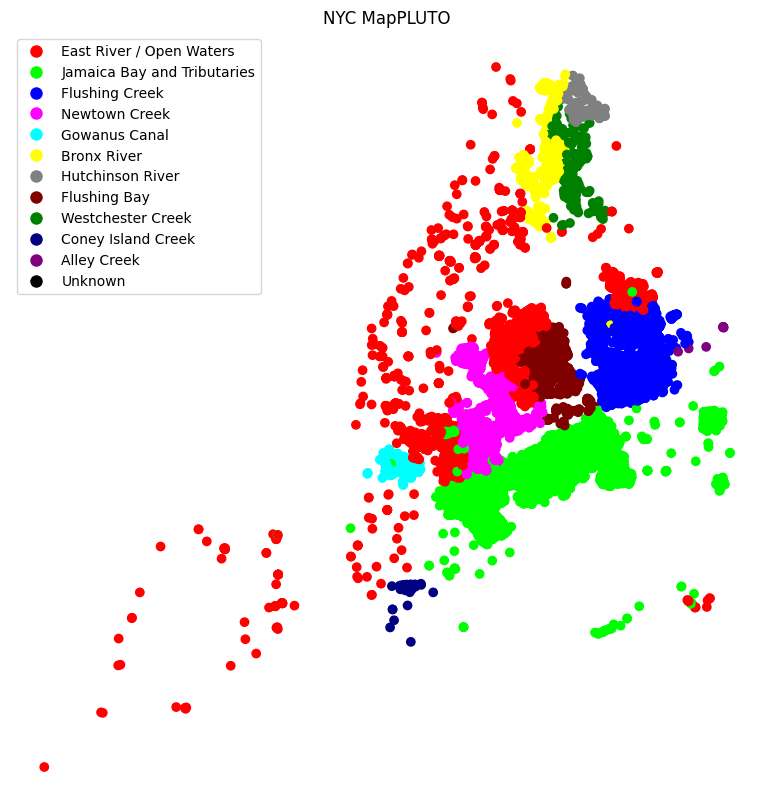

In [32]:
ax = pluto_ogrio.plot(
    color=pluto_ogrio["color"],
    figsize=(10, 10),
    legend=True,
).set_axis_off()
plt.title("NYC MapPLUTO")


# populate legend items based on dict from above
legend_colors = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

Text(0.5, 1.0, 'NYC MapPLUTO')

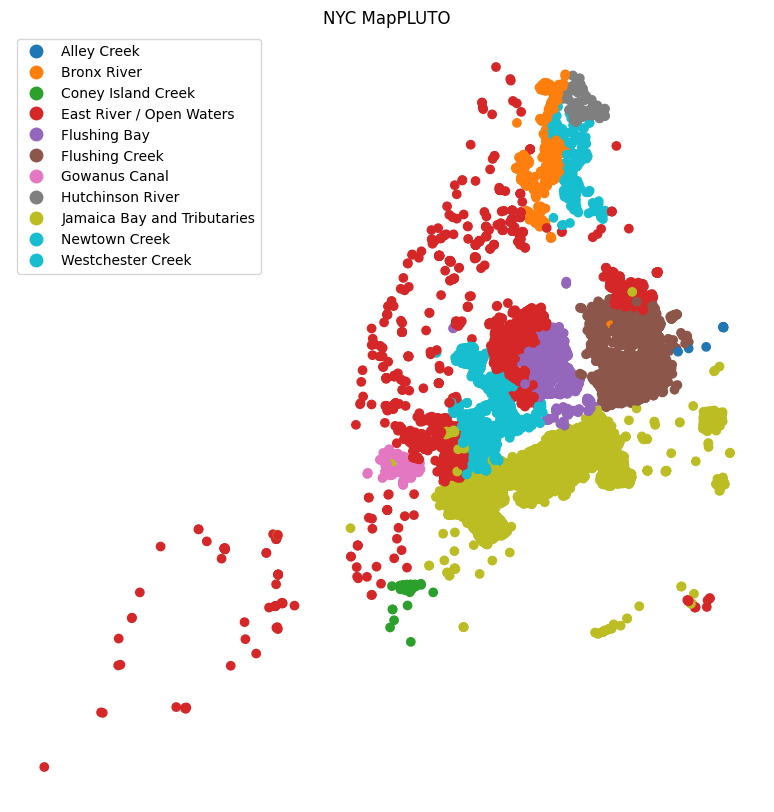

In [33]:
pluto_ogrio.plot(
    column="nyc_waters", figsize=(10, 10), legend=True, legend_kwds={"loc": "upper left"}
).set_axis_off()
plt.title("NYC MapPLUTO")

## Your turn:

- map a numeric column using a continuous colormap for Queens. See here for a list and discussion of colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
- What patterns emerge?


# prep for interactive mapping


In [89]:
pluto_ogrio_wgs = pluto_ogrio.to_crs("epsg:4326")

## visualize a categorical variable


In [92]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

In [93]:
cmap_rgb

{'One & Two Family Buildings': [255, 0, 0],
 'Multi-Family Walk-Up Buildings': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [94]:
len(pluto_ogrio_wgs[pluto_ogrio_wgs["LandUse"].isna()])

2649

In [95]:
pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_47985/961482650.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)


## uhoh- observe the above warning- re-write the code to avoid this


## now, we can plot the data using lonboard to create an interactive map


In [96]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x1cd1059c0>
[
  [
    128,
…

In [35]:
pluto_ogrio_wgs["LandUse"] = pluto_ogrio_wgs["LandUse"].astype("category")

In [36]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x165160280>
[
  [
    128,
…

In [55]:
pluto_ogrio_wgs[pluto_ogrio_wgs.geometry.isna()]

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,NumFloorsCluster,color


## visualize a continuous variable


In [101]:
df = pluto_ogrio_wgs[["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

layer = PolygonLayer.from_geopandas(
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x1ceca89a0>
[
  42,
 …

## your turn: can you make the above show in 3d?

- see here for some tips: https://developmentseed.org/lonboard/latest/examples/overture-maps/#imports


# save data


In [ ]:
# save out as fgb using geopandas
# pluto_ogrio.to_file("..Data/nyc_mappluto_24v1_1_shp/mappluto.fgb")

In [ ]:
# ogr.write_dataframe(pluto_ogrio, "../Data/nyc_mappluto_24v1_1_shp/mappluto_ogr.fgb")